Maybe from switching models, but I got a wierd error that the trainer couldn't train.
I thought perhaps it was a Torch setting, hence below.
But it was to install `sudo apt-get install python3.11-dev`

In [62]:
import os
# os.environ.update({
#     # "TORCH_COMPILE_DISABLE": "1",
#     # "PYTORCH_DISABLE_TRITON_INFERENCE": "1", 
#     # "TRITON_DISABLE_LINE_INFO": "1"
#     "TOKENIZERS_PARALLELISM": True
# })

In [63]:
from collections import Counter
import json
import sqlite3
import pandas as pd
from datasets import Dataset
from pathlib import Path
import logging
import re

import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    pipeline
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils import resample, shuffle
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
from datetime import datetime
from typing import List
from enum import Enum
import spacy
import matplotlib.pyplot as plt

import shutil
import glob

The following is just a work in progress - but this config will help for building and testing I hope.

In [64]:
class FileConfig:
    __FullRunContext = """denotes using the complete dataset of just a smaller portion of it for testing."""
    FullRun = True

    __MiniRunContext = """denotes using a mini dataset for testing. If FullRun is True this is ignored."""
    MiniRun = True

    __ModelVersionContext = """To keep things in order, you may set model version here."""
    ModelVersion = "v0.1.4"

    ## NOTE: currently not in use for this file
    __Percentage = """If NOT a full run, what percentage of data do we use? (Think decimal values 0 < pc < 1)"""
    Percentage = 0.1
    
    __ToBuildContext = """Do we want to build another model or run without build for testing purposes."""
    ToBuild = True

    __CustomLossFnContext = """For certain cases with class imbalance we need a custom loss function."""
    CustomLossFn = False
    
    __ChunkOverlapContext = """For the vector store, chunks are 64 words with 8 word overlap."""
    ChunkOverlap = 8

    # Don't know why an option, it's basically required.
    UsePadding = True

    # BaseModelName = "bert-base-uncased" # Context too small
    BaseModelName = "answerdotai/ModernBERT-base"
    # I think ModernBert allows for 512 * 16 = 8192
    MaxTokens = 512 * 2
    Hardware = 'cuda' if torch.cuda.is_available() else 'cpu'

# class Labels(Enum)
LabelMap = Enum(
    'LabelMap', 
    [
        ('SUPPORTS', 0),
        ('REFUTES', 1),
        ('NOT ENOUGH INFO', 2),
    ]
)
print(f"HARDWARE: {FileConfig.Hardware}")

HARDWARE: cuda


In [65]:
# FULL_RUN denotes using all the dataset or a small bit of it for testing the process
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Turned out the database was 52GB of Wikipedia articles, but the dataset fit OK in one file so chunking wasn't necessary...
Keeping the logic though.

## Loading Data

I've vectorized the evidence best I can so it matches the inputs it will receive.

In [66]:
def load_processed_fever(output_dir: Path, filestart: str,  max_chunks=None):
    """
    Load processed FEVER data from disk
    
    Args:
        output_dir: Directory containing processed chunks
        max_chunks: Maximum number of chunks to load (None for all)
    """
    output_path = Path(output_dir).resolve()
    assert output_path.exists()
    
    # Find all parquet files
    parquet_files = sorted(output_path.glob(f"{filestart}*.parquet"))
    
    if max_chunks:
        parquet_files = parquet_files[:max_chunks]
    
    logger.info(f"Loading {len(parquet_files)} chunks from {output_path}")
    
    # Load and combine all chunks
    dfs = []
    for file in parquet_files:
        df = pd.read_parquet(file)
        dfs.append(df)
        logger.info(f"Loaded {file.name}: {len(df)} samples")
    
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        logger.info(f"Total samples loaded: {len(combined_df)}")
        return Dataset.from_pandas(combined_df)
    else:
        logger.warning("No data files found!")
        return None
    
# processed_data_home = Path(__file__).resolve().parent / '.datasets' / 'vectorized'
processed_data_home = Path('.').resolve() / '.datasets' / 'vectorized'
pda = load_processed_fever(processed_data_home, 'fever_train_balanced') ##all I have now
pdfa = pd.DataFrame(pda)

x = pdfa.drop('label', axis=1)
y = pdfa['label']

# x_train, x_test, y_train, y_test = train_test_split(
#     x, y,
#     test_size=0.1,
#     stratify=y,
#     random_state=42,
# )

# x_train, x_test, y_train, y_test = train_test_split(
#     x, y,
#     test_size=0.1,
#     stratify=y,
#     random_state=42,
# )

# -----------------------------------
# -----------------------------------
x_all = pdfa.drop('label', axis=1)
y_all = pdfa['label']
print(len(x))
print(len(y))
lth_all = len(x_all)
tenpc = int(len(x_all) * 0.1)
print(tenpc)
x_test, x_tmp, y_test, y_tmp = train_test_split(
    x_all, y_all,
    test_size=(len(x_all) - tenpc),
    stratify=y,
    random_state=42,
)
print(f"X Tmp: {len(x_tmp)}")
print(f"X test: {len(x_test)}")
print(f"Y Tmp: {len(y_tmp)}")
print(f"y Test: {len(y_test)}")
print(tenpc)

x_val, x_train, y_val, y_train = train_test_split(
    x_tmp, y_tmp,
    test_size=(len(x_tmp) - tenpc),
    stratify=y_tmp,
    random_state=42,
)
print(f"X Train: {len(x_train)}")
print(f"X Val: {len(x_val)}")
print(f"Y Tmp: {len(y_train)}")
print(f"y Test: {len(y_val)}")
# -----------------------------------
# -----------------------------------

# Train for training
pdft = x_train.copy()
pdft['label'] = y_train.values

# Dev for testing
pdfd = x_test.copy()
pdfd['label'] = y_test.values

# Validation for validation
pdfv = x_val.copy()
pdfv['label'] = y_val.values


# I don't have split data at moment. 
# pds = load_processed_fever(processed_data_home, 'fever_dev_chunk')
# pdfd = pd.DataFrame(pds)
pdft.head()

INFO:__main__:Loading 1 chunks from /home/ksull18/code/iu-autonomous-fact-checker/aieng/judge_model/.datasets/vectorized
INFO:__main__:Loaded fever_train_balanced_001.parquet: 7500 samples
INFO:__main__:Total samples loaded: 7500


7500
7500
750
X Tmp: 6750
X test: 750
Y Tmp: 6750
y Test: 750
750
X Train: 6000
X Val: 750
Y Tmp: 6000
y Test: 750


,id,claim,evidence,challenge,titles,pages,vector_evidence,evidence_count,label
569,22309,Caguas (a historic place in central Puerto Ric...,"[Caguas (Spanish pronunciation: [ˈkaɣwas), fou...",multi-hop reasoning,"[Caguas, Puerto Rico]","[Caguas,_Puerto_Rico]","[{'chunk_id': 'Caguas,_Puerto_Rico_chunk_0012'...",5,NOT ENOUGH INFO
488,75389,"Tommy Pico, who was a well-known graphic artis...",[Tommy Pico is an indigenous (Kumeyaay Nation)...,other,[Tommy Pico],[Tommy_Pico],"[{'chunk_id': 'Marco_Anelli_chunk_0001', 'cont...",5,NOT ENOUGH INFO
432,86073,Union Slough National Wildlife Refuge is locat...,"[Union Slough National Wildlife Refuge, locate...",other,[Union Slough National Wildlife Refuge],[Union_Slough_National_Wildlife_Refuge],[{'chunk_id': 'Union_Slough_National_Wildlife_...,4,REFUTES
1711,90055,Tammy Cantoni does not know how to play pool.,[Tammy Cantoni (born 25 August 1972) is an Aus...,other,[Tammy Cantoni],[Tammy_Cantoni],"[{'chunk_id': 'Tammy_Cantoni_chunk_0000', 'con...",5,REFUTES
4722,41225,Battle of the Pinal Mountains happened one day...,[The exact date of the battle is unknown but h...,combining tables and text,[Battle of the Pinal Mountains],[Battle_of_the_Pinal_Mountains],"[{'chunk_id': 'Chapultepec_chunk_0012', 'conte...",5,NOT ENOUGH INFO


In [101]:
print("Training Data")
print(pdft['label'].value_counts())
print(len(pdft))

Training Data
label
REFUTES            2000
SUPPORTS           2000
NOT ENOUGH INFO    2000
Name: count, dtype: int64
6000


In [102]:
print('Testing Data')
print(pdfd['label'].value_counts())
print(len(pdfd))

Testing Data
label
SUPPORTS           250
REFUTES            250
NOT ENOUGH INFO    250
Name: count, dtype: int64
750


In [103]:
print('Validation Data')
print(pdfv['label'].value_counts())
print(len(pdfv))

Validation Data
label
NOT ENOUGH INFO    250
SUPPORTS           250
REFUTES            250
Name: count, dtype: int64
750


In [68]:
# what is not enough data?
mask = pdft["label"] == "NOT ENOUGH INFO"
print(mask)
baddf = pdft[mask]

# could also go with iloc
for index, row in baddf.head(10).iterrows():
    print(f"{index + 1}.) {row['claim']}")
    print("Evidence:")
    for t in row['evidence']:
        print(f"  {t}")
    print("---"*10)

569      True
488      True
432     False
1711    False
4722     True
        ...  
6730    False
330      True
1602    False
5123    False
5776     True
Name: label, Length: 6000, dtype: bool
570.) Caguas (a historic place in central Puerto Rico) had seven listings on the registry of Historic Places, and five of these listings are found in Caguas Pueblo, pueblo means it contains a central plaza, the municipal buildings (city hall), and a Catholic church.
Evidence:
  Caguas (Spanish pronunciation: [ˈkaɣwas), founded in 1775, is a city and municipality of Puerto Rico located in the Central Mountain Range of Puerto Rico, south of San Juan and Trujillo Alto, west of Gurabo and San Lorenzo, and east of Aguas Buenas, Cidra, and Cayey.
------------------------------
489.) Tommy Pico, who was a well-known graphic artist,  grew up in Los Altos Hills In California and had started collecting comics and zines of famous writers at the age of five.
Evidence:
  Tommy Pico is an indigenous (Kumeyaay 

# Model Training

Going to follow pretty close to how I trained the claim extractor / detector model.
Going to finetune BERT first I think as the context might not be big enough in DistilBERT for the evidence.

## Data Preparation

I saved the entire evidence in the 'vector_evidence' so not to lose something and need to recreate datasets... again.
However, now we must update our 'evidence' column here... 
Don't overwrite any files!

In [69]:
pdft.head()

,id,claim,evidence,challenge,titles,pages,vector_evidence,evidence_count,label
569,22309,Caguas (a historic place in central Puerto Ric...,"[Caguas (Spanish pronunciation: [ˈkaɣwas), fou...",multi-hop reasoning,"[Caguas, Puerto Rico]","[Caguas,_Puerto_Rico]","[{'chunk_id': 'Caguas,_Puerto_Rico_chunk_0012'...",5,NOT ENOUGH INFO
488,75389,"Tommy Pico, who was a well-known graphic artis...",[Tommy Pico is an indigenous (Kumeyaay Nation)...,other,[Tommy Pico],[Tommy_Pico],"[{'chunk_id': 'Marco_Anelli_chunk_0001', 'cont...",5,NOT ENOUGH INFO
432,86073,Union Slough National Wildlife Refuge is locat...,"[Union Slough National Wildlife Refuge, locate...",other,[Union Slough National Wildlife Refuge],[Union_Slough_National_Wildlife_Refuge],[{'chunk_id': 'Union_Slough_National_Wildlife_...,4,REFUTES
1711,90055,Tammy Cantoni does not know how to play pool.,[Tammy Cantoni (born 25 August 1972) is an Aus...,other,[Tammy Cantoni],[Tammy_Cantoni],"[{'chunk_id': 'Tammy_Cantoni_chunk_0000', 'con...",5,REFUTES
4722,41225,Battle of the Pinal Mountains happened one day...,[The exact date of the battle is unknown but h...,combining tables and text,[Battle of the Pinal Mountains],[Battle_of_the_Pinal_Mountains],"[{'chunk_id': 'Chapultepec_chunk_0012', 'conte...",5,NOT ENOUGH INFO


In [70]:
pdfd.head()

,id,claim,evidence,challenge,titles,pages,vector_evidence,evidence_count,label
3464,72435,Erna Baumbauer (8 January 1919 – 30 January 20...,[The awards ceremony is traditionally held in ...,multi-hop reasoning,[Deutscher Filmpreis],[Deutscher_Filmpreis],"[{'chunk_id': 'Eva_Krížiková_chunk_0002', '...",2,REFUTES
1113,46321,The Spring ball start of practice date for Boi...,[This was Boise State's final season as a WAC ...,combining tables and text,[2010 Western Athletic Conference football sea...,[2010_Western_Athletic_Conference_football_sea...,[{'chunk_id': '2010_Western_Athletic_Conferenc...,5,SUPPORTS
1658,44311,Gaurav Wadhwa is an Indian television actor an...,[He used to run a Youtube channel called RiMoR...,other,[Gaurav Wadhwa],[Gaurav_Wadhwa],"[{'chunk_id': 'Gaurav_Wadhwa_chunk_0001', 'con...",2,REFUTES
2081,71783,In the 1930 United States Senate election in T...,[Senator Morris Sheppard was re-elected to a f...,other,[1930 United States Senate election in Texas],[1930_United_States_Senate_election_in_Texas],[{'chunk_id': '1930_United_States_Senate_elect...,5,REFUTES
1453,50632,"Ike Ugbo played for Barnsley, an English profe...",[Barnsley Football Club is an English associat...,other,[List of Barnsley F.C. seasons],[List_of_Barnsley_F.C._seasons],"[{'chunk_id': 'Ash_Kigbu_chunk_0000', 'content...",3,REFUTES


In [104]:
pdfv.head()

,id,claim,evidence,challenge,titles,pages,vector_evidence,evidence_count,label
7240,59081,"Ronald Cass, born on May 21, 1923 in Llanelli,...","[Ronald Cass (21 April 1923 – 2 June 2006), al...",other,[Ronald Cass],[Ronald_Cass],"[{'chunk_id': 'Ronald_Cass_chunk_0005', 'conte...",5,NOT ENOUGH INFO
4396,91839,"The Clemson Tigers, representing Clemson Unive...",[The 1969 Clemson Tigers football team was an ...,combining tables and text,[1969 Clemson Tigers football team],[1969_Clemson_Tigers_football_team],[{'chunk_id': '1969_Clemson_Tigers_football_te...,5,SUPPORTS
6125,30869,Edvard Grimstad finally settled on his family ...,[He was briefly a research assistant here in 1...,other,[Edvard Grimstad],[Edvard_Grimstad],"[{'chunk_id': 'Jacob_Volhard_chunk_0001', 'con...",5,NOT ENOUGH INFO
6349,74309,Xenia Wickett is falsely believed to have serv...,"[Prior to her NSC post, Wickett served as a Fo...",other,[Xenia Wickett],[Xenia_Wickett],"[{'chunk_id': 'Cricket_chunk_0110', 'content':...",5,NOT ENOUGH INFO
1829,23152,Sarawak Biodiversity Centre filed a patent (gi...,"[In 2002, the centre filed a patent for a cycl...",multi-hop reasoning,[Sarawak Biodiversity Centre],[Sarawak_Biodiversity_Centre],[{'chunk_id': 'Sarawak_Biodiversity_Centre_chu...,5,SUPPORTS


In [105]:
for i,j in pdfd.iterrows():
    print(f"{i} {j['vector_evidence']}")
    break
    # if i > 3:
    #     break

# each row (j) = Index(['id', 'claim', 'evidence', 'challenge', 'titles', 'pages',
# 'vector_evidence', 'evidence_count', 'label'], dtype='object')
# -------------
# vector_evidence is a list
# elements (k) of list (l) are dict_keys(['chunk_id', 'content', 'metadata', 'query_text', 'query_type', 'similarity_score'])
# metadata = 1 dict_keys(['chunk_index', 'page', 'source_url', 'title', 'total_chunks'])
spacy_nlp = spacy.load('en_core_web_sm')

def combine_chunks_in_data(df: pd.DataFrame) -> List[List[str]]:
    store = []
    for i, j in df.iterrows():
        row_store = []
        l = j['vector_evidence']
        ev = j['evidence']

        if len(l) == 0:
            if ev is None or len(ev) == 0:
                store.append([])
                continue
            else:
                store.append(ev)
                continue

        # Group by URL
        groups = {}
        for k in l:
            md = k['metadata']
            url = md.get('source_url')
            if url is None:
                continue

            datum = {
                'evidence': k.get('content'),
                'url': url,
                'index': md.get('chunk_index')
            }
            if url not in groups:
                groups[url] = []
            groups[url].append(datum)
        
        # Process each URL group
        for url, chunks in groups.items():
            chunks.sort(key=lambda x: x['index'])
            
            if not chunks:
                continue
            
            # Combine consecutive chunks
            i = 0
            while i < len(chunks):
                current_chunk = chunks[i]['evidence']
                
                # Look ahead for consecutive chunks
                j = i + 1
                while j < len(chunks) and chunks[j]['index'] == chunks[j-1]['index'] + 1:
                    next_content = chunks[j]['evidence']
                    words = next_content.split()
                    if len(words) > FileConfig.ChunkOverlap:
                        next_content_no_overlap = ' '.join(words[FileConfig.ChunkOverlap:])
                        current_chunk = f"{current_chunk} {next_content_no_overlap}"
                    j += 1
                
                # Add the combined chunk
                row_store.append(current_chunk)
                
                # Move to next non-consecutive chunk
                i = j
        
        store.append(row_store)
    
    return store

pdft['evidence'] = combine_chunks_in_data(pdft)
pdfd['evidence'] = combine_chunks_in_data(pdfd)
pdfv['evidence'] = combine_chunks_in_data(pdfv)
pdft.head(5)


0 [{'chunk_id': 'Farrukhnagar_chunk_0000', 'content': 'Farrukhnagar is a small town and municipality in Farrukhnagar tehsil of Gurugram district in the Indian state of Haryana. It is situated 21 kilometres (13 mi) from Gurgaon and shares its border with Jhajjar district. It was established in 1732 by Faujdar Khan, the first Nawab of Farrukhnagar and a governor of the Mughal Emperor Farrukhsiyar. Farrukhnagar flourished due to its salt trade until', 'metadata': {'chunk_index': 0, 'page': 'Farrukhnagar', 'source_url': 'https://en.wikipedia.org/wiki/Farrukhnagar', 'title': 'Farrukhnagar', 'total_chunks': 32}, 'query_text': 'Farrukhnagar is in India whose capital is New Delhi, it is a town and municipality in Gurugram district of Haryana state.Farrukhnagar is a town and municipality in Gurugram district (formerly Gurgaon) of Haryana state, India.', 'query_type': 'claim', 'similarity_score': 0.8038716018199921}, {'chunk_id': 'Farrukhnagar_chunk_0002', 'content': 'The Sultanpur National Park

,id,claim,evidence,challenge,titles,pages,vector_evidence,evidence_count,label,input
0,15699,"Prime House in Huntington, New York was built ...",[Prime House is a historic home located at Hun...,other,[Prime House],[Prime_House],"[{'chunk_id': 'Prime_House_chunk_0000', 'conte...",1,REFUTES,"[CLS] CLAIM: Prime House in Huntington, New Yo..."
1,89522,Midfielder Pascal Johansen began his career wi...,[Pascal Johansen (born 28 April 1979) is a Fre...,other,[Pascal Johansen],[Pascal_Johansen],"[{'chunk_id': 'Pascal_Johansen_chunk_0002', 'c...",5,SUPPORTS,[CLS] CLAIM: Midfielder Pascal Johansen began ...
2,92227,"Cypress Ridge High School, established in 2002...",[Cypress Ridge High School is a public seconda...,combining tables and text,[Cypress Ridge High School],[Cypress_Ridge_High_School],[{'chunk_id': 'Cypress_Ridge_High_School_chunk...,5,SUPPORTS,"[CLS] CLAIM: Cypress Ridge High School, establ..."
3,28655,Andrzej Paczkowski was a director at the Polit...,"[Andrzej Paczkowski (born 1 October 1938, Kras...",other,[Andrzej Paczkowski],[Andrzej_Paczkowski],"[{'chunk_id': 'Andrzej_Paczkowski_chunk_0000',...",5,SUPPORTS,[CLS] CLAIM: Andrzej Paczkowski was a director...
4,36499,"On February 19, 1981, Gore accosted Ying Ling ...","[September 29, 1952, in New Jersey. He is a fo...",other,[David Alan Gore],[David_Alan_Gore],"[{'chunk_id': 'David_Alan_Gore_chunk_0005', 'c...",5,REFUTES,"[CLS] CLAIM: On February 19, 1981, Gore accost..."


In [72]:
print(json.dumps(pdft.iloc[0]['evidence'], indent=2))

[
  "United States Department of War conducted a census of Puerto Rico finding that the population of Caguas was 19,857. The city grew considerably in size during the 1970s and quickly became an exurb of San Juan to the north due to its location. The region of Caguas became an important pharmaceuticals manufacturing center during this time. Pharmaceutical companies originally came to Puerto Rico in",
  "the colloquial \u00c1rea Metro of San Juan (San Juan, Cata\u00f1o, Bayam\u00f3n, Guaynabo and Carolina), the municipality of Caguas is located in the census-based San Juan Metropolitan Area due to its role as a commuter town. The average commute time for residents of the municipality is 30.5 minutes. Caguas is the fourth most populous city in the San Juan Metropolitan region and the most populous",
  "the Morales neighborhood. Escuela Segunda Unidad Diego V\u00e1zquez and the Centro Multiusos flooded as well. Geography The city and municipality of Caguas are located approximately 30 min

In [73]:
# Data Shuffle
for _ in range(3):
    pdft = pdft.sample(frac=1, replace=False, ignore_index=True)
    pdfd = pdfd.sample(frac=1, replace=False, ignore_index=True)

## Loading and Setup with BERT

### Initialize Tokenizer and Model

In [74]:
# Loading tokenizer for this model
tokenizer = AutoTokenizer.from_pretrained(FileConfig.BaseModelName)
# dir(tokenizer)

In [75]:
# Ran into tokenization issue - All tensors in a batch should be same length
# Some were 100 and but one was 187.
# Use padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [76]:
model = AutoModelForSequenceClassification.from_pretrained(
    FileConfig.BaseModelName, 
    num_labels=3,  # Yay, Nay, Not enough info
)
model.to(FileConfig.Hardware)

print(f"Model loaded: {FileConfig.BaseModelName}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: answerdotai/ModernBERT-base
Vocabulary size: 50280


### Tokenize Data

Unlike the claim_extractor model, which just had the claim and a label, this model has claims and evidence, and 3 labels. 
I believe our tokenizer must handle the proper combination.

In [77]:
def data_transform(claim: str, evidence: List[str]):
    """
    This will be used later when we need to actually use this model.
    """
    if isinstance(evidence, list):
        evidence_text = " ".join(evidence)
    else:
        evidence_text = str(evidence)
    
    # Update for BERT Specific
    return f"[CLS] CLAIM: {claim} [SEP] EVIDENCE: {evidence_text} [SEP]"
    # return f"CLAIM: {claim} EVIDENCE: {evidence_text}"


Loading tokenizer: answerdotai/ModernBERT-base
Analyzing 6000 texts...
Processed 1000 texts...
Processed 2000 texts...
Processed 3000 texts...
Processed 4000 texts...
Processed 5000 texts...
Processed 6000 texts...

TOKEN LENGTH STATISTICS
Total samples: 6,000
Average length: 439.4 tokens
Median length: 461.0 tokens
Standard deviation: 114.8
Min length: 34 tokens
Max length: 927 tokens

PERCENTILES:
25th percentile: 414.0 tokens
50th percentile: 461.0 tokens
75th percentile: 502.0 tokens
90th percentile: 546.0 tokens
95th percentile: 581.0 tokens
99th percentile: 676.0 tokens

RECOMMENDATIONS:
✅ Recommended max_length: 1024 (covers 95% of data)

Data truncated at different max_lengths:
  max_length=256: 90.3% truncated
  max_length=512: 20.3% truncated
  max_length=768: 0.2% truncated
  max_length=1024: 0.0% truncated
  max_length=2048: 0.0% truncated


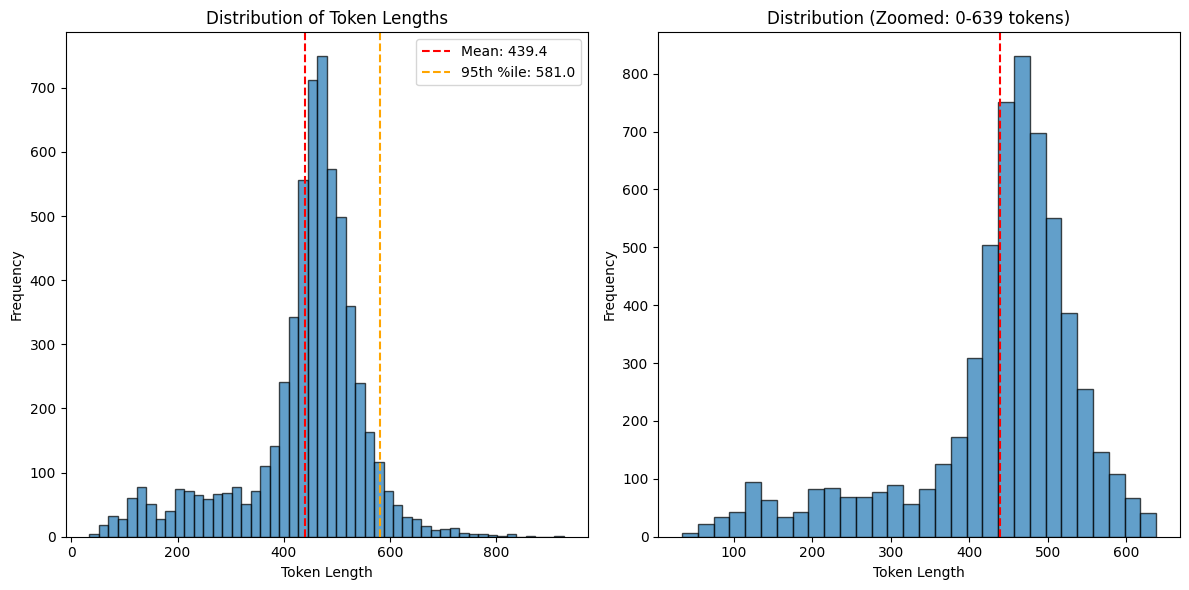

Loading tokenizer: answerdotai/ModernBERT-base
Analyzing 750 texts...

TOKEN LENGTH STATISTICS
Total samples: 750
Average length: 434.8 tokens
Median length: 461.0 tokens
Standard deviation: 115.4
Min length: 57 tokens
Max length: 760 tokens

PERCENTILES:
25th percentile: 411.2 tokens
50th percentile: 461.0 tokens
75th percentile: 503.0 tokens
90th percentile: 539.0 tokens
95th percentile: 565.1 tokens
99th percentile: 652.0 tokens

RECOMMENDATIONS:
✅ Recommended max_length: 1024 (covers 95% of data)

Data truncated at different max_lengths:
  max_length=256: 89.5% truncated
  max_length=512: 19.7% truncated
  max_length=768: 0.0% truncated
  max_length=1024: 0.0% truncated
  max_length=2048: 0.0% truncated


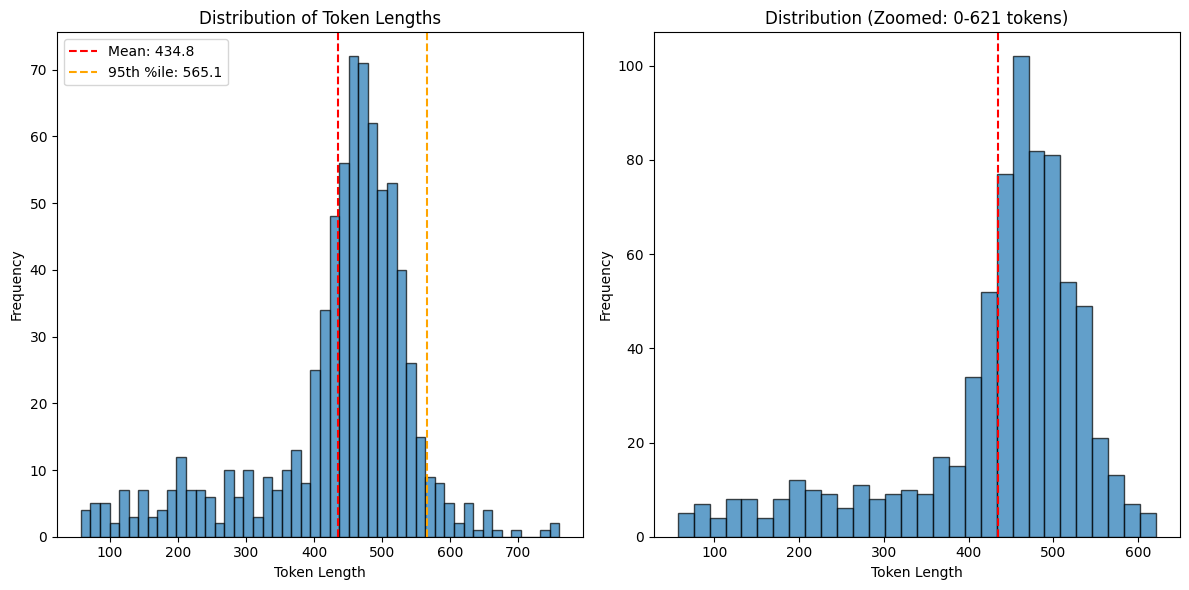

In [ ]:
# Find good max token length...
def analyze_token_lengths(df, text_column='text', tokenizer_name='answerdotai/ModernBERT-base'):
    """
    Analyze token lengths in your dataset
    
    Args:
        df: pandas DataFrame
        text_column: name of column containing text
        tokenizer_name: HuggingFace tokenizer to use
    """
    
    # Load tokenizer
    print(f"Loading tokenizer: {tokenizer_name}")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    # Get all texts
    texts = df[text_column].tolist()
    print(f"Analyzing {len(texts)} texts...")
    
    # Tokenize without truncation to get true lengths
    token_lengths = []
    
    # Process in batches for efficiency
    batch_size = 100
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        tokenized = tokenizer(
            batch_texts, 
            truncation=False,  # Don't truncate - we want true lengths
            padding=False,     # Don't pad
            return_tensors=None
        )
        
        # Get lengths
        batch_lengths = [len(tokens) for tokens in tokenized['input_ids']]
        token_lengths.extend(batch_lengths)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch_texts)} texts...")
    
    # Calculate statistics
    token_lengths = np.array(token_lengths)
    
    stats = {
        'count': len(token_lengths),
        'mean': np.mean(token_lengths),
        'median': np.median(token_lengths),
        'std': np.std(token_lengths),
        'min': np.min(token_lengths),
        'max': np.max(token_lengths),
        '25th_percentile': np.percentile(token_lengths, 25),
        '50th_percentile': np.percentile(token_lengths, 50),
        '75th_percentile': np.percentile(token_lengths, 75),
        '90th_percentile': np.percentile(token_lengths, 90),
        '95th_percentile': np.percentile(token_lengths, 95),
        '99th_percentile': np.percentile(token_lengths, 99)
    }
    
    # Print results
    print("\n" + "="*50)
    print("TOKEN LENGTH STATISTICS")
    print("="*50)
    print(f"Total samples: {stats['count']:,}")
    print(f"Average length: {stats['mean']:.1f} tokens")
    print(f"Median length: {stats['median']:.1f} tokens")
    print(f"Standard deviation: {stats['std']:.1f}")
    print(f"Min length: {stats['min']} tokens")
    print(f"Max length: {stats['max']:,} tokens")
    print()
    print("PERCENTILES:")
    print(f"25th percentile: {stats['25th_percentile']:.1f} tokens")
    print(f"50th percentile: {stats['50th_percentile']:.1f} tokens")
    print(f"75th percentile: {stats['75th_percentile']:.1f} tokens")
    print(f"90th percentile: {stats['90th_percentile']:.1f} tokens")
    print(f"95th percentile: {stats['95th_percentile']:.1f} tokens")
    print(f"99th percentile: {stats['99th_percentile']:.1f} tokens")
    
    # Recommendations based on percentiles
    print("\n" + "="*50)
    print("RECOMMENDATIONS:")
    print("="*50)
    
    if stats['95th_percentile'] <= 256:
        print("  Recommended max_length: 256 (covers 95% of data)")
    elif stats['95th_percentile'] <= 512:
        print("  Recommended max_length: 512 (covers 95% of data)")
    elif stats['90th_percentile'] <= 512:
        print("️!  Consider max_length: 512 (covers 90% of data)")
        print(f"   Note: {100-90:.1f}% of samples will be truncated")
    elif stats['95th_percentile'] <= 1024:
        print("  Recommended max_length: 1024 (covers 95% of data)")
    else:
        print(f"  Consider max_length: {int(stats['95th_percentile'])} (covers 95% of data)")
        print("   Or use 1024 if you want faster training with some truncation")
    
    print(f"\nData truncated at different max_lengths:")
    for max_len in [256, 512, 768, 1024, 2048]:
        pct_truncated = (token_lengths > max_len).mean() * 100
        print(f"  max_length={max_len}: {pct_truncated:.1f}% truncated")
    
    # Create histogram
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(token_lengths, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Lengths')
    plt.axvline(stats['mean'], color='red', linestyle='--', label=f'Mean: {stats["mean"]:.1f}')
    plt.axvline(stats['95th_percentile'], color='orange', linestyle='--', label=f'95th %ile: {stats["95th_percentile"]:.1f}')
    plt.legend()
    
    # Zoomed in view (up to 95th percentile)
    plt.subplot(1, 2, 2)
    zoom_limit = min(int(stats['95th_percentile'] * 1.1), stats['max'])
    zoom_data = token_lengths[token_lengths <= zoom_limit]
    plt.hist(zoom_data, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title(f'Distribution (Zoomed: 0-{zoom_limit} tokens)')
    plt.axvline(stats['mean'], color='red', linestyle='--', label=f'Mean: {stats["mean"]:.1f}')
    
    plt.tight_layout()
    plt.show()
    
    return stats, token_lengths

pdft.head(2)
pdft['input'] = pdft.apply(lambda x: data_transform(x['claim'], x['evidence']), axis=1)
pdfd['input'] = pdfd.apply(lambda x: data_transform(x['claim'], x['evidence']), axis=1)

statst, token_lengthst = analyze_token_lengths(pdft, text_column='input')
statsd, token_lengthsd = analyze_token_lengths(pdfd, text_column='input')

> Perhaps a point of improvement - better input and separation of claims and evidence. 

In [79]:
def tokenize_fn(dataset):
    # Combine claim and evidence into single text input
    texts = []
    for claim, evidence in zip(dataset['claim'], dataset['evidence']):
        combined_text = data_transform(claim, evidence)
        texts.append(combined_text)

    # Due to issues around tensor length - get actual max length or default to what worked.
    max_len = getattr(tokenizer, 'model_max_length', 512)
    print('Max Tokens for Model: {max_len}')
    max_len = min(FileConfig.MaxTokens, max_len)
    print(f"Token Length picked: {max_len}")

    model_inputs = tokenizer(
        texts,
        truncation=True,
        padding=FileConfig.UsePadding,
        # Tensor Size returned is 1021 and doesn't match the 512...
        # max_length=(2**10)
        max_length=max_len,
        # return_tensors=None, # not necessary once correct lenght established
    )

    label_map = {"SUPPORTS": 0, "REFUTES": 1, "NOT ENOUGH INFO": 2}
    if isinstance(dataset['label'], list):
        # batched
        model_inputs["label"] = [label_map[label] for label in dataset['label']]
    else:
        model_inputs["label"] = [label_map[dataset['label']]]

    return model_inputs

#### Data Debugging

The training is not working because it says the labels are a list...

In [80]:
# Checking the structure of your pandas data before conversion
if False:
    print("Sample rows from pdft:")
    print(pdft[['claim', 'evidence', 'label']].head(2))
    print("\nData types:")
    print(pdft[['claim', 'evidence', 'label']].dtypes)
    print("\nSample evidence type:")
    print(type(pdft['evidence'].iloc[0]))
    print("Sample evidence content:")
    print(pdft['evidence'].iloc[0])
    print("\nSample label type:")
    print(type(pdft['label'].iloc[0]))
    pdft[['claim', 'evidence', 'label']].head(2)

### Constant...

LABELS is for computing class weights later...

In [81]:
LABELS = pdft['label'].values

In [82]:
min(pdft['label'].value_counts())

2000

[This StackOverflow post](https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows) lists several ways to shuffle a dataframe. 
Pandas has the builtin `df = df.sample(frac=1).reset_index(drop=True)` which apparently reassigns but does not recreate.
SciKit Learn also has a "shuffle" method but that might require resetting indexes.
There are then seemingly countless ways after that as well...

Side note on sample - it now has an 'ignore_index' param to help with that reset issue.

In [83]:
# Convert pandas DataFrames to 🤗 Dataset objects
if FileConfig.FullRun:
    print("Full Run!")
    dst = Dataset.from_pandas(pdft[['claim', 'evidence', 'label']])
    dsv = Dataset.from_pandas(pdfd[['claim', 'evidence', 'label']])
elif FileConfig.MiniRun:
    print("Mini Run!")
    # mini-datasets for running into issues... 😖
    # should probably go in the data processing section
    # there's probably an easier way...
    training_mini = pd.concat([
        pdft[pdft['label'] == 'SUPPORTS'].sample(n=100, replace=False, ignore_index=True),
        pdft[pdft['label'] == 'REFUTES'].sample(n=100, replace=False, ignore_index=True),
        pdft[pdft['label'] == 'NOT ENOUGH INFO'].sample(n=100, replace=False, ignore_index=True),
    ])

    val_mini = pd.concat([
        pdfd[pdfd['label'] == 'SUPPORTS'].sample(n=20, replace=False, ignore_index=True),
        pdfd[pdfd['label'] == 'REFUTES'].sample(n=20, replace=False, ignore_index=True),
        pdfd[pdfd['label'] == 'NOT ENOUGH INFO'].sample(n=20, replace=False, ignore_index=True),
    ])

    ## Shuffle data
    for _ in range(5):
        training_mini = training_mini.sample(frac=1, replace=False, ignore_index=True)
        val_mini = val_mini.sample(frac=1, replace=False, ignore_index=True)

    print(training_mini['label'].value_counts())
    print(val_mini['label'].value_counts())
    dst = Dataset.from_pandas(training_mini[['claim', 'evidence', 'label']])
    dsv = Dataset.from_pandas(val_mini[['claim', 'evidence', 'label']])

    ## REDO Labels - shouldn't be too different
    LABLES = training_mini['label'].values
else:
    # This is not ready yet
    pc = FileConfig.Percentage
    print(f"Partial Run of {pc:.02%}")


    # NEW STRATEGY
    numr = min(pdft['label'].value_counts()) * 2
    training_mini = pd.concat([
        pdft[pdft['label'] == 'SUPPORTS'].sample(n=numr, replace=False, ignore_index=True),
        pdft[pdft['label'] == 'REFUTES'].sample(n=numr, replace=False, ignore_index=True),
        # allowing replacement here.
        pdft[pdft['label'] == 'NOT ENOUGH INFO'].sample(n=numr, replace=True, ignore_index=True),
    ])

    val_mini = pd.concat([
        pdfd[pdfd['label'] == 'SUPPORTS'].sample(frac=1, replace=False, ignore_index=True),
        pdfd[pdfd['label'] == 'REFUTES'].sample(frac=1, replace=False, ignore_index=True),
        pdfd[pdfd['label'] == 'NOT ENOUGH INFO'].sample(frac=1, replace=False, ignore_index=True),
    ])

    # Shuffling / Randomizing data
    for _ in range(5):
        training_mini = training_mini.sample(frac=1, replace=False, ignore_index=True)
        val_mini = val_mini.sample(frac=1, replace=False, ignore_index=True)

    print(training_mini['label'].value_counts())
    print(val_mini['label'].value_counts())
    dst = Dataset.from_pandas(training_mini[['claim', 'evidence', 'label']])
    dsv = Dataset.from_pandas(val_mini[['claim', 'evidence', 'label']])

    ## REDO Labels - shouldn't be too different
    LABLES = training_mini['label'].values

# Apply tokenization
train_dataset = dst.map(
    tokenize_fn, 
    batched=True,
    remove_columns=dst.column_names,
)
val_dataset = dsv.map(
    tokenize_fn, 
    batched=True,
    remove_columns=dsv.column_names,
)

print("Data tokenized successfully!")

Full Run!


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Max Tokens for Model: {max_len}
Token Length picked: 1024


Map:  17%|█▋        | 1000/6000 [00:00<00:01, 2720.09 examples/s]

Max Tokens for Model: {max_len}
Token Length picked: 1024


Map:  33%|███▎      | 2000/6000 [00:00<00:01, 2909.18 examples/s]

Max Tokens for Model: {max_len}
Token Length picked: 1024


Map:  50%|█████     | 3000/6000 [00:01<00:01, 2803.34 examples/s]

Max Tokens for Model: {max_len}
Token Length picked: 1024


Map:  67%|██████▋   | 4000/6000 [00:01<00:00, 2875.10 examples/s]

Max Tokens for Model: {max_len}
Token Length picked: 1024


Map:  83%|████████▎ | 5000/6000 [00:01<00:00, 2971.48 examples/s]

Max Tokens for Model: {max_len}
Token Length picked: 1024


Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Max Tokens for Model: {max_len}
Token Length picked: 1024


Map: 100%|██████████| 750/750 [00:00<00:00, 3416.62 examples/s]

Data tokenized successfully!


In [84]:
train_dataset.description

''

In [85]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.6


The below helped me find a mismatch in data-types between the dataset I thought I was making and what was really created...
which the training did not like.

In [86]:
# Check the dataset structure after conversion from pandas
if False:
    print("Dataset columns:", dst.column_names)
    print("Dataset features:", dst.features)
    print("First example:")
    try:
        print(dst[0])
    except Exception as e:
        print(f"Error accessing first example: {e}")

    # Check if there are any problematic column names or types
    for col in dst.column_names:
        print(f"Column '{col}' type: {type(dst[col])}")
        try:
            print(f"First value: {dst[col][0]}")
            print(f"First value type: {type(dst[col][0])}")
        except Exception as e:
            print(f"Error accessing column '{col}': {e}")
        print("---")

    print("="*25)

    print("Dataset columns:", train_dataset.column_names)
    print("Dataset features:", train_dataset.features)
    print("First example:")
    try:
        print(train_dataset[0])
    except Exception as e:
        print(f"Error accessing first example: {e}")

    # Check if there are any problematic column names or types
    for col in train_dataset.column_names:
        print(f"Column '{col}' type: {type(train_dataset[col])}")
        try:
            print(f"First value: {train_dataset[col][0]}")
            print(f"First value type: {type(train_dataset[col][0])}")
        except Exception as e:
            print(f"Error accessing column '{col}': {e}")
        print("---")

## Fine-Tune the Model

We are doing **transfer learning** with **fine-tuning**. 
BERT was pre-trained to understand language - Thank you!
We fine-tuning the model for a specific task - claim vs opinion here.
The technique = Supervised learning with backpropagation

Deep dive: BERT has millions of weights to understand language. We are adjusting these to suit our classification task. Only our final classification layer is learning from scratch. The rest of BERT is merely adapting instead of being completely retrained. 
BERT (I think) expects a "[MASK]" token to predict values. 
By fine-tuning, we add a layer like: `input text -> BERT Encoder -> Classification Head -> [Claim, Opinion] probabilities`.

### Defining Training Arguments

> I am taking most of this from the claim_extractor I made previously

In [87]:
# Set up directories for saving
datenow = datetime.now()
timestamp = datenow.strftime("%Y%m%d%H%M%S")

# TODO: Give model name at top
move_path = Path().cwd() / "trainingresults" / f'hide-modernbert_{timestamp}'
out_path = Path().cwd() / "trainingresults" / "latest"
metatdata_file_path = out_path / "metadata.json"

# Below is the logic for moving previous versions
if FileConfig.ToBuild:
    if metatdata_file_path.exists():
        # A model exists in latest already - move to it's timestamp

        try:
            with open(metatdata_file_path, 'r') as file:
                tmp = json.load(file)
                str_path = tmp.get('path', None)
                assert str_path is not None
                ts_path = Path(str_path)
                # Moving the old model into its timestamp directory
                out_path.rename(ts_path)
        except Exception as e:
            logger.warning(e)
            # suggests something in directory didn't finish and should probably be deleted?
        assert not out_path.exists()

    ## Open cannot make the directories after I rename them...
    out_path.mkdir(parents=True, exist_ok=True)

    with open(out_path / "metadata.json", 'w') as file:
        json.dump({"path": str(move_path), "foundation": FileConfig.BaseModelName, 'timestamp': datenow.isoformat(), "version": FileConfig.ModelVersion}, file, indent=2)

In [88]:
## OLD
# training_args = TrainingArguments(
#     output_dir=out_path, # Working directory during training for logs and checkpoints.
#     num_train_epochs=3,              # Start with 3, adjust based on results
#     ## batch size of 16 gets to 5.6/6GB of RTX 3060
#     per_device_train_batch_size=8,  # Reduce if memory issues
#     per_device_eval_batch_size=16,
#     warmup_steps=500, # gradually increase learning rate over 1000 steps | prevents huge descrutive changes early on
#     weight_decay=0.01, # Very mild 1% to prevent memorizing training data exactly. 
#     logging_dir='./logs',
#     ## had set to 10 which is a lot of overhead
#     logging_steps=20,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     greater_is_better=False,
#     dataloader_pin_memory=False, # can help with GPU transfer speed
#     fp16=True, # mixed precision can speedup training if supported
#     dataloader_num_workers=4, # parallel data loading
# )

# New'ish
# I increased Epochs and changed the saving and eval strategies to Steps
training_args = TrainingArguments(
    output_dir=out_path, # Working directory during training for logs and checkpoints.
    num_train_epochs=3 if FileConfig.FullRun else 1,              # Start with 3, adjust based on results
    ## batch size of 16 gets to 5.6/6GB of RTX 3060
    per_device_train_batch_size=4,  # Reduce if memory issues
    per_device_eval_batch_size=4,
    warmup_steps=1000 if FileConfig.FullRun else 50, # gradually increase learning rate over 1000 steps | prevents huge descrutive changes early on
    weight_decay=0.01, # Very mild 1% to prevent memorizing training data exactly. 
    logging_dir='./logs',
    ## had set to 10 which is a lot of overhead
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=500 if FileConfig.FullRun else 100,
    save_strategy="steps",
    save_steps=500 if FileConfig.FullRun else 100,
    load_best_model_at_end=True,
    metric_for_best_model="f1", # Changing for balanced data
    greater_is_better=True, # updated
    dataloader_pin_memory=False, # can help with GPU transfer speed
    fp16=True, # mixed precision can speedup training if supported
    dataloader_num_workers=4, # parallel data loading
)

### Define Evaluation Metrics

SciKit Learn has some handy prebuilt functions.

In [89]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Custome Weights

The data is quite unbalanced.
There is a total of 48,205 entries:
- supports = 31,811
- refutes = 14,610
- na = 1,784

Rebalancing to the tiny amount is not desireable.
The `Trainer` can take in a loss function. The signature is just 'Callable' so inside the class it takes in `(outputs, labels, num_items_in_batch)`.

There are several loss functions to consider:
- 


[SciKit-Learn's `compute_class_weight`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) function follows the inverse frequency approach.

In [90]:
for I,J in enumerate(LabelMap):
    print(I)
    print(str(J))

LabelMap['SUPPORTS'].name

0
LabelMap.SUPPORTS
1
LabelMap.REFUTES
2
LabelMap.NOT ENOUGH INFO


'SUPPORTS'

In [91]:
def create_weights(labels):
    unique_labels = np.unique(labels)
    weights_balanced = compute_class_weight('balanced', classes=unique_labels, y=labels)
    weight_tensor = torch.zeros(3)

    for index, en in enumerate(LabelMap):
        label_inx = np.where(unique_labels == en.name)[0][0]
        weight_tensor[index] = weights_balanced[label_inx]
    
    return weight_tensor

class_weights = create_weights(LABELS)
class_weights = class_weights.to(model.device)
print(class_weights)

# This needs work, I don't think weights should change nor be calucated during each batch...
def custom_weighted_loss_fn(outputs, labels, num_items_in_batch=None):
    logits = outputs.logits # Model's raw predictions [batch_size, 3]

    # Method 1: Balanced - Inverse Frequency
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    # This is impure function for now
    loss = loss_fn(logits, labels)
    return loss
    

tensor([1., 1., 1.], device='cuda:0')


### Initialize and Train!

In [92]:
print(len(train_dataset))
print(len(val_dataset))

6000
750


Randomly getting error: trying `sudo apt-get install build-essential`
NO
did `sudo apt-get install python3.11-dev`

Seems working now...

In [93]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator if FileConfig.UsePadding else None,
    compute_metrics=compute_metrics,
    compute_loss_func=custom_weighted_loss_fn if FileConfig.CustomLossFn else None,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # if no improvements
    optimizers=(None, None), # Letting Trainer handle optimizer
)

# Start training
print("Starting training...")
if FileConfig.ToBuild:
    trainer.train()
    # Save the model
    trainer.save_model(out_path) # Where to save model weights and config
    tokenizer.save_pretrained(out_path) # for tokenizer stuff
    print("Model saved!")
    print("Cleaning up Checkpoints...")
    checkpoint_dirs = glob.glob(f"{out_path}/checkpoint-*")
    for checkpoint_dir in checkpoint_dirs:
        shutil.rmtree(checkpoint_dir)
    print("Clean up complete!")

Starting training...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,1.090900,0.913690,0.484000,0.415685,0.493063,0.484000
1000,0.698000,0.950868,0.581333,0.546350,0.571172,0.581333
1500,0.694500,0.682230,0.693333,0.683088,0.704591,0.693333
2000,0.534900,0.737140,0.742667,0.738416,0.745191,0.742667
2500,0.489800,0.691010,0.738667,0.725100,0.738427,0.738667
3000,0.596600,0.688029,0.748000,0.742947,0.747547,0.748000
3500,0.471300,0.912862,0.760000,0.758808,0.758533,0.760000
4000,0.434100,0.932465,0.762667,0.759957,0.764846,0.762667
4500,0.146400,0.923190,0.761333,0.758552,0.761415,0.761333


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Model saved!
Cleaning up Checkpoints...
Clean up complete!


## Test the Model

This is kind of the manual process I suppose for the time being.

### Loading Model

Loading from hugging face consumes too much VRAM

In [94]:
class TextClassifier:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        # Ensure token length
        self.tokenizer.model_max_length = FileConfig.MaxTokens
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map=FileConfig.Hardware,
        )
        self.model.eval()
    
    def __call__(self, text):
        # To not track gradients to save memory - don't need back propagation
        with torch.no_grad():
            inputs = self.tokenizer(
                text, 
                return_tensors="pt", 
                truncation=True,
                # max_length=FileConfig.MaxTokens, 
                padding=True
            )
            inputs = {k: v.to(FileConfig.Hardware) for k, v in inputs.items()}
            outputs = self.model(**inputs)
            
            # Format like pipeline output
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred_id = torch.argmax(probs, dim=-1).item()
            
            # Same as Hugging Face
            return [{
                'label': self.model.config.id2label[pred_id],
                'score': probs[0][pred_id].item()
            }]


In [95]:
print("\n")
# Load your fine-tuned model
# TODO: UPDATE!!!
if False:
    the_judge = pipeline(
        task="text-classification",
        model=str(out_path),
        tokenizer=str(out_path),
        device=FileConfig.Hardware,
        # For memory:
        torch_dtype=torch.float16,
        model_kwargs={"torch_dtype": torch.float16},
        tokenizer_kwargs={"max_length": 1012, "truncation": True}  # Force this length
    )
else:
    the_judge = TextClassifier(str(out_path))

Making up some claims and support for manual testing

In [96]:
fake_test_data = [
    # SUPPORTS - 4 claims
    {
        "id": 1,
        "claim": "The 2024 US presidential election had the highest voter turnout in history.",
        "evidence": [
            "According to the Federal Election Commission, approximately 158 million Americans voted in the 2024 presidential election. This surpassed the previous record of 155 million voters set in 2020. Election officials reported that turnout reached 66.8% of eligible voters, marking a new milestone in American electoral participation.",
        ],
        "label": "SUPPORTS",
        "context": "Short and factual about voter turnout."
    },
    {
        "id": 2, 
        "claim": "Social Security benefits increased by 3.2% in 2024.",
        "evidence": [
            "The Social Security Administration announced a 3.2% cost-of-living adjustment for 2024 benefits. This increase affects over 67 million Social Security beneficiaries and 7 million SSI recipients. The adjustment was based on the Consumer Price Index data from the third quarter of 2023.",
        ],
        "label": "SUPPORTS",
        "context": "Matching percentages."
    },
    {
        "id": 3,
        "claim": "The federal minimum wage in America is $7.25 per hour.",
        "evidence": [
            "The federal minimum wage has remained at $7.25 per hour since July 2009, when it was last increased under the Fair Minimum Wage Act. While many states have implemented higher minimum wages, the federal rate serves as the baseline for all states. Congressional attempts to raise the federal minimum wage to $15 per hour have stalled in recent legislative sessions.",
        ],
        "label": "SUPPORTS",
        "context": "Simple fact about minimum wage."
    },
    {
        "id": 4,
        "claim": "Medicare covers prescription drug costs for seniors.",
        "evidence": [
            "Medicare Part D provides prescription drug coverage for Medicare beneficiaries, covering approximately 63 million seniors and disabled individuals. The program was established in 2006 and helps reduce out-of-pocket prescription costs. Recent legislation has also capped annual prescription drug costs at $2,000 starting in 2025 for Medicare recipients.",
        ],
        "label": "SUPPORTS",
        "context": "More evidence for slightly more vague claim."
    },
    # REFUTES - 4 claims  
    {
        "id": 5,
        "claim": "The US Constitution requires congressional approval for all military deployments overseas.",
        "evidence": [
            "The Constitution grants Congress the power to declare war, but does not require congressional approval for all military actions. The President, as Commander in Chief, has authority to deploy troops for limited periods without congressional authorization. The War Powers Resolution of 1973 requires congressional approval only for deployments lasting more than 60 days.",
        ],
        "label": "REFUTES",
        "context": "A constitutional misconception."
    },
    {
        "id": 6,
        "claim": "Climate change legislation was passed by Congress in 2023 with bipartisan support.",
        "evidence": [
            "No major climate change legislation received bipartisan support in Congress during 2023. The Inflation Reduction Act, which included climate provisions, was passed in 2022 with only Democratic votes. Several climate-related bills were introduced in 2023 but failed to advance due to partisan disagreements over implementation and funding mechanisms.",
        ],
        "label": "REFUTES",
        "context": "A false bipartisan claim about climate legislation."
    },
    {
        "id": 7,
        "claim": "The federal deficit decreased by 50% in 2024.",
        "evidence": [
            "The Congressional Budget Office reported that the federal deficit increased by approximately 8% in fiscal year 2024, reaching $1.9 trillion. This represents a significant increase from the previous year's deficit of $1.7 trillion. Rising interest payments on national debt and increased government spending contributed to the larger deficit.",
        ],
        "label": "REFUTES",
        "context": "A favourite for some, incorrect percentages."
    },
    {
        "id": 8,
        "claim": "All Supreme Court justices must be confirmed by a two-thirds majority in the Senate.",
        "evidence": [
            "Supreme Court nominees require only a simple majority vote for confirmation in the Senate, not a two-thirds majority. This threshold was established by Senate rules and precedent. The confirmation process involves Senate Judiciary Committee hearings followed by a full Senate vote, where 51 votes are sufficient for confirmation.",
        ],
        "label": "REFUTES",
        "context": "Incorrect claim about voting threshold."
    },
    # NOT ENOUGH INFO - 2 claims
    {
        "id": 9,
        "claim": "The new infrastructure bill will create 500,000 jobs in rural communities specifically.",
        "evidence": [
            "The Infrastructure Investment and Jobs Act allocated $1.2 trillion for various infrastructure projects across the United States. The legislation includes funding for roads, bridges, broadband expansion, and water systems. Economic analysts project the bill will create millions of jobs nationwide over the next decade, with significant benefits expected for both urban and rural areas.",
        ],
        "label": "NOT ENOUGH INFO",
        "context": "Evidence is about the project but without the supporting figures."
    },
    {
        "id": 10,
        "claim": "Congressional approval ratings reached their lowest point since 1974 last month.",
        "evidence": [
            "Recent polling shows Congress has historically low approval ratings, with multiple surveys indicating public dissatisfaction with legislative performance. Gallup polling has tracked congressional approval since the 1970s, showing significant fluctuations over the decades. Political polarization and gridlock have contributed to declining public confidence in the institution.",
        ],
        "label": "NOT ENOUGH INFO",
        "context": "Evidence does not specify exact timeframe nor comparison to 1974."
    },
    {
        "id": 11,
        "claim": "Trump and Putin are meeting in Alaska to talk about ending the war in Ukraine.",
        "evidence": [],
        "label": "NOT ENOUGH INFO",
        "context": "Very recent news as of today, withholding evidence even though it does techincally exist."
    }
]



Above: I was going to do the multiple sentences but when we pass data into the model I zip them up anyways so... it's half done for now.

In [97]:
# Create DataFrame and Dataset
def create_fake_dataset():
    """Create fake dataset for testing judge model"""
    df = pd.DataFrame(fake_test_data)
    
    print("Test Dataset Summary:")
    print(f"Total samples: {len(df)}")
    print("\nLabel Distribution:")
    label_counts = df['label'].value_counts()
    for label, count in label_counts.items():
        print(f"{label}: {count}")
    
    print("\nClaim Length Statistics:")
    df['claim_length'] = df['claim'].str.len()
    print(f"Average claim length: {df['claim_length'].mean():.0f} characters")
    print(f"Shortest claim: {df['claim_length'].min()} characters")
    print(f"Longest claim: {df['claim_length'].max()} characters")
    
    return Dataset.from_pandas(df)

# Create the dataset
test_dataset = create_fake_dataset()

Test Dataset Summary:
Total samples: 11

Label Distribution:
SUPPORTS: 4
REFUTES: 4
NOT ENOUGH INFO: 3

Claim Length Statistics:
Average claim length: 71 characters
Shortest claim: 45 characters
Longest claim: 90 characters


In [98]:
# for each test_case
for tc in test_dataset:
    print(f"TEST CASE: {tc['id']:02}")
    print(f"Claim: {tc['claim']}")
    print(f"Evidence: ")
    for x in [y for y in tc['evidence']]:
        print(f"  {x}")
    expected = tc['label']
    print(f"Label: {expected}")
    print(f"ABOUT: {tc['context']}")
    fixed = data_transform(tc['claim'], tc['evidence'])
    result_list = the_judge(fixed)
    result = result_list[0]
    print("RESULT:", json.dumps(result, indent=2))
    actual = result.get('label')
    if "0" in actual:
        actual = "SUPPORTS"
    elif "1" in actual:
        actual = "REFUTES"
    elif "2" in actual:
        actual = "NOT ENOUGH INFO"
    else:
        actual = "ERROR - WHAT?!?"
    print()
    correct = actual == expected
    if correct:
        print(f"✅ PREDICTED: {actual} | ACTUAL: {tc['label']}")
    else:
        print(f"❌ PREDICTED: {actual} | ACTUAL: {tc['label']}")
    print()

TEST CASE: 01
Claim: The 2024 US presidential election had the highest voter turnout in history.
Evidence: 
  According to the Federal Election Commission, approximately 158 million Americans voted in the 2024 presidential election. This surpassed the previous record of 155 million voters set in 2020. Election officials reported that turnout reached 66.8% of eligible voters, marking a new milestone in American electoral participation.
Label: SUPPORTS
ABOUT: Short and factual about voter turnout.
RESULT: {
  "label": "LABEL_0",
  "score": 0.93310546875
}

✅ PREDICTED: SUPPORTS | ACTUAL: SUPPORTS

TEST CASE: 02
Claim: Social Security benefits increased by 3.2% in 2024.
Evidence: 
  The Social Security Administration announced a 3.2% cost-of-living adjustment for 2024 benefits. This increase affects over 67 million Social Security beneficiaries and 7 million SSI recipients. The adjustment was based on the Consumer Price Index data from the third quarter of 2023.
Label: SUPPORTS
ABOUT: Mat

I know the validation data shouldn't be used, but just checking here for fun...

In [106]:
t_preds = []
t_labels = []

# I've created pdfv - never seen before.

if not FileConfig.FullRun:
    print('Minifying Validation Dataset')
    min_n = min(pdfd['label'].value_counts())
    min_n = 100
    pdfv = pd.concat([
            pdfv[pdfv['label'] == 'SUPPORTS'].sample(n=min_n, replace=False, ignore_index=True),
            pdfv[pdfv['label'] == 'REFUTES'].sample(n=min_n, replace=False, ignore_index=True),
            pdfv[pdfv['label'] == 'NOT ENOUGH INFO'].sample(n=min_n, replace=False, ignore_index=True),
        ])

print('Validation Data')
print(pdfv['label'].value_counts())

for _, row in pdfv.iterrows():
    fixed = data_transform(row['claim'], row['evidence'])
    result_list = the_judge(fixed)
    result = result_list[0]
    actual = result.get('label')
    expected = row['label']
    if "0" in actual:
        actual = "SUPPORTS"
    elif "1" in actual:
        actual = "REFUTES"
    elif "2" in actual:
        actual = "NOT ENOUGH INFO"
    else:
        actual = "ERROR - WHAT?!?"
    t_preds.append(actual)
    t_labels.append(expected)

def compute_metrics_simple(predicted_values: List[str], actual_values: List[str]):
    precision, recall, f1, _ = precision_recall_fscore_support(
        actual_values, predicted_values, average='weighted'
    )
    accuracy = accuracy_score(actual_values, predicted_values)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
test_results = compute_metrics_simple(t_preds, t_labels)
print(json.dumps(test_results, indent=2))

Validation Data
label
NOT ENOUGH INFO    250
SUPPORTS           250
REFUTES            250
Name: count, dtype: int64
{
  "accuracy": 0.7666666666666667,
  "f1": 0.7670789101317896,
  "precision": 0.7685564138074107,
  "recall": 0.7666666666666667
}


In [107]:
print(pdfv['label'].value_counts())
print()
print(len(t_preds))
print()
mycounts = {}
for exp, act in zip(t_preds, t_labels):
    try:
        mycounts[exp][act] += 1
    except:
        one = mycounts.get(exp)
        if one is None:
            mycounts[exp] = {}
        mycounts[exp][act] = 1

print(json.dumps(mycounts, indent=2))

label
NOT ENOUGH INFO    250
SUPPORTS           250
REFUTES            250
Name: count, dtype: int64

750

{
  "NOT ENOUGH INFO": {
    "NOT ENOUGH INFO": 229,
    "REFUTES": 8,
    "SUPPORTS": 8
  },
  "SUPPORTS": {
    "SUPPORTS": 183,
    "REFUTES": 79,
    "NOT ENOUGH INFO": 7
  },
  "REFUTES": {
    "REFUTES": 163,
    "SUPPORTS": 59,
    "NOT ENOUGH INFO": 14
  }
}
